# บทที่ 4 โครงข่ายประสาทเทียมเชิงสังวัตนาการ

จากบทที่ผ่านมาเราได้ศึกษาโมเดล DNN ขั้นพื้นฐาน หรือที่เรียกกันอีกชื่อหนึ่งว่า MLP (multi-layer perceptron) 
ที่ใช้งานได้ดีในปัญหาการเรียนรู้เชิงลึกโดยทั่วไป แต่จากตัวอย่างที่เกี่ยวข้องกับการประมวลผลภาพ 
กลับพบว่าได้ความแม่นยำค่อนข้างต่ำถึงแม้ว่าจะปรับปรุงโมเดลโดยวิธีการในบทที่ 3 แล้วก็ตาม 
สาเหตุสำคัญคือการเรียนรู้โดย DNN ส่วนรับอินพุตจะแปลงพิกเซลของภาพเป็นเวกเตอร์ราบ (flatten) 
โดยไม่ได้ใช้ประโยชน์จากข้อมูลเชิงพื้นที่ (spatial) ซึ่งเป็นองค์ประกอบสำคัญของภาพที่ต้องการประมวลผล 
เราสามารถทดลองได้โดยเรียงพิกเซลในแต่ละภาพใหม่แบบสุ่มก่อนทำการฝึก 
ความแม่นยำที่ได้จากโมเดลจะไม่แตกต่างจากเดิมแม้ว่าในสายตามนุษย์ไม่สามารถจำแนกได้แล้วว่าเป็นภาพอะไร

สถาปัตยกรรมของโครงข่ายประสาทเทียมเชิงลึกที่จะศึกษาในบทนี้มีชื่อเรียกว่า โครงข่ายประสาทเทียมเชิงสังวัตนาการ
(convolutional neural network) มีชื่อย่อว่า CNN 
เป็นการผสมผสานวิธีการประมวลผลภาพโดยคอมพิวเตอร์ที่ใช้งานอย่างแพร่หลายก่อนหน้าที่จะมีการพัฒนาการเรียนรู้เชิงลึก 
เพื่อดึงลักษณะเด่นเชิงพื้นที่ของภาพ เช่นการตรวจจับขอบของวัตถุในภาพ เมื่อนำการสังวัตนาการมาสร้างเป็นชั้นด้านอินพุตของโมเดลที่มีพารามิเตอร์การเรียนรู้ 
พบว่าสามารถได้ความแม่นยำในการจำแนกภาพที่สูงกว่า DNN อย่างมากในขณะที่ใช้พารามิเตอร์น้อยกว่า จนในปัจจุบันการเรียนรู้เชิงลึกด้านภาพจะใช้ 
CNN เป็นหลัก

นำเข้าไลบรารีของไพธอนที่ใช้ในบทนี้

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
from scipy import signal,misc, ndimage

2022-06-08 16:44:50.964627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 16:44:50.964644: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


In [ ]:
# use history.history in agrument 
def plot_acc_loss(history):
    acc=history['accuracy']
    val_acc=history['val_accuracy']
    loss=history['loss']
    val_loss=history['val_loss']
    epochs=range(len(acc)) # Get number of epochs

    acc_txt = str(round(acc[len(acc)-1]*100,2))
    val_acc_txt = str(round(val_acc[len(val_acc)-1]*100,2))

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(epochs, acc,'r',epochs,val_acc,'b')
    ax1.set_title('Training and validation accuracy')
    ax1.legend(["Training acc = "+acc_txt+" %","Validation acc = "+val_acc_txt+" %"])

    loss_txt = str(round(loss[len(loss)-1],2))
    val_loss_txt = str(round(val_loss[len(val_loss)-1],2))

    ax2.plot(epochs, loss, 'r',epochs, val_loss, 'b')
    ax2.legend(["Training loss = "+loss_txt,"Validation loss = "+val_loss_txt])
    ax2.set_title('Training and validation loss');


In [13]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2022-06-08 17:28:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4001:80a::2010, 2404:6800:4001:806::2010, 2404:6800:4001:809::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4001:80a::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  32.5MB/s    in 2.0s    

2022-06-08 17:29:02 (32.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



เรียกไลบรารีของระบบปฏิบัติการเพื่อเข้าถึงและแตกไฟล์

In [14]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

โดยไฟล์จะถูกเก็บในไดเรคทอรีฐาน /tmp/cats_and_dogs_filtered แยกเป็นไดเรคทอรีย่อย train และ validation 
และภายในประกอบด้วยไดเรคทอรีย่อย cats และ dogs เพื่อความสะดวกในการใช้งาน ImageGenerator นิยามเส้นทางไปยังข้อมูลฝึกและตรวจสอบดังนี้

In [15]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


ดูชื่อไฟล์บางไฟล์ในแต่ละประเภทของสัตว์เลี้ยง และจำนวนภาพทั้งหมดที่ใช้ในการฝึกและตรวจสอบ

In [16]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.920.jpg', 'cat.10.jpg', 'cat.999.jpg', 'cat.320.jpg', 'cat.744.jpg', 'cat.264.jpg', 'cat.880.jpg', 'cat.257.jpg', 'cat.757.jpg', 'cat.8.jpg']
['dog.164.jpg', 'dog.91.jpg', 'dog.301.jpg', 'dog.974.jpg', 'dog.824.jpg', 'dog.944.jpg', 'dog.707.jpg', 'dog.401.jpg', 'dog.795.jpg', 'dog.6.jpg']


In [17]:
print('จำนวนภาพแมวสำหรับฝึก :', len(os.listdir(      train_cats_dir ) ))
print('จำนวนภาพสุนัขสำหรับฝึก :', len(os.listdir(      train_dogs_dir ) ))

print('จำนวนภาพแมวสำหรับตรวจสอบ :', len(os.listdir( validation_cats_dir ) ))
print('จำนวนภาพสุนัขสำหรับตรวจสอบ :', len(os.listdir( validation_dogs_dir ) ))

จำนวนภาพแมวสำหรับฝึก : 1000
จำนวนภาพสุนัขสำหรับฝึก : 1000
จำนวนภาพแมวสำหรับตรวจสอบ : 500
จำนวนภาพสุนัขสำหรับตรวจสอบ : 500


ทดลองแสดงบางภาพในรูปแบบ $4 \times 4$ สำหรับแต่ละประเภท เริ่มจากการเรียกไลบรารี กำหนดค่าจำนวนแถว คอลัมน์ และตัวชี้

In [18]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4
pic_index = 0 


เอาต์พุตในรูปที่ 4.10 จะเปลี่ยนไปตามลำดับในชุดข้อมูลสำหรับทุกครั้งของการรันเซลล์ด้านล่างนี้ โดยสองแถวบนเป็นภาพแมวและสองแถวล่างเป็นสุนัข 
สังเกตว่าข้อมูลเป็นภาพสีที่มีขนาดแตกต่างกัน บางภาพมีสัตว์เลี้ยงมากกว่าหนึ่งตัว หรือมีมนุษย์อยู่ด้วย 

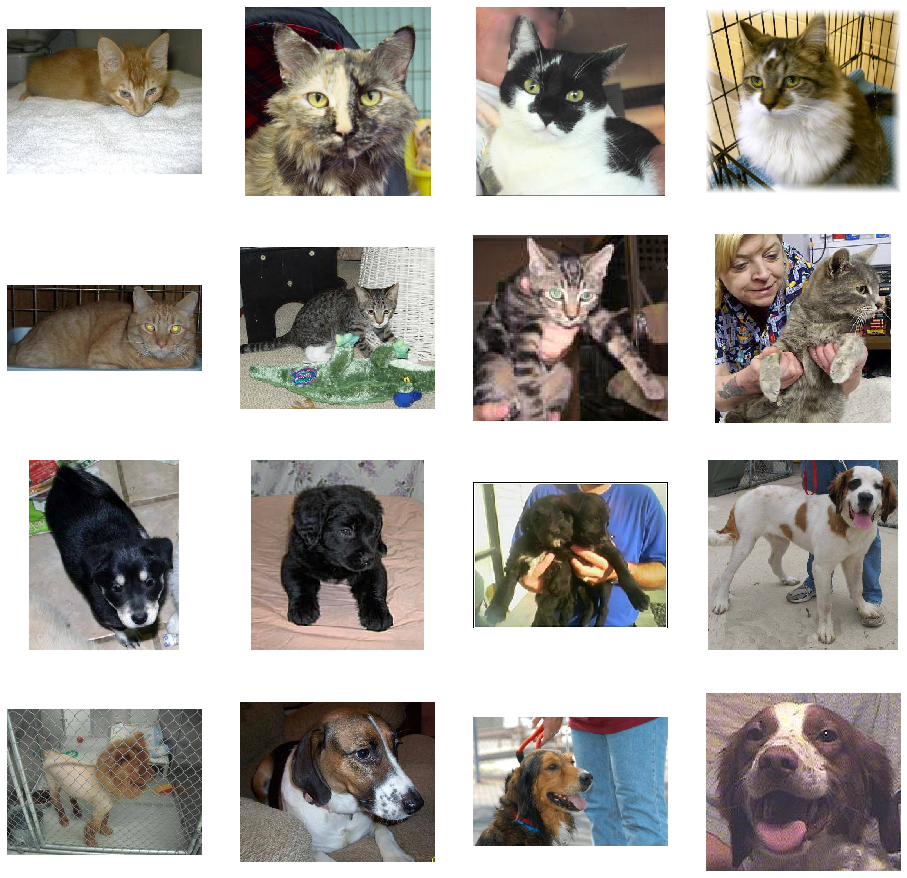

In [19]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


รูปที่ 4.10 ตัวอย่างภาพแมวและสุนัขที่ใช้ในการฝึก

นำเข้าไลบรารีที่ต้องการ และนิยามให้ใช้งานง่ายขึ้น ชั้นที่นำเข้าใหม่ในบทนี้คือ Conv2D() สำหรับการสังวัตนาการ และ MaxPooling2D() สำหรับการทำพูลลิง 
ที่เหลือคือที่เราเคยใช้งานแล้วก่อนหน้านี้

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten 
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


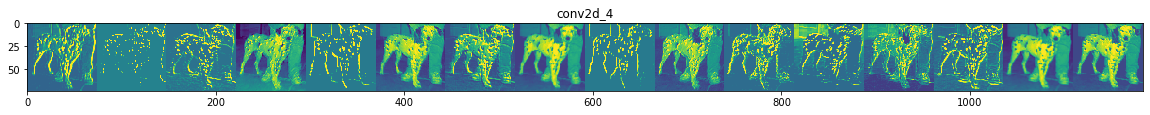

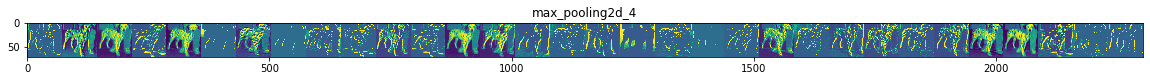

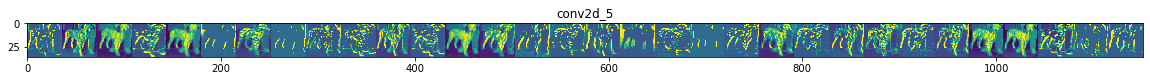

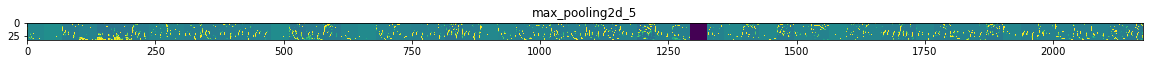

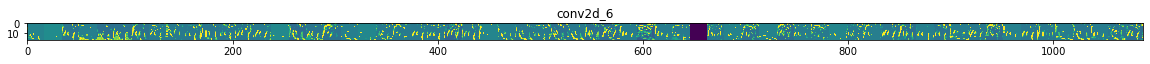

In [50]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid


    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

รูปที่ 4.12 เอาต์พุตจากชั้นสังวัตนาการและพูลลิงในโมเดล CNN

แม้ว่ามนุษย์อาจสื่อความหมายจากเอาต์พุตจากรูปที่ 4.12 ได้ไม่ดีนัก แต่พอสังเกตได้ถึงหลักการของการเรียนรู้เชิงลึกโดย CNN 
โดยภาพในชั้นล่างลงมาจะมีรายละเอียดของภาพน้อยลง แต่พยายามจับเฉพาะลักษณะเด่นของภาพที่โมเดลให้ความสนใจ เช่นส่วนขอบของตัวสัตว์  

ผู้อ่านสามารถทดสอบโมเดลกับภาพสัตว์เลี้ยงของท่านได้โดยใส่ภาพที่ไดเรคทอรีย่อย /content/ กำหนดตัวแปร fn ในโค้ดด้านล่างนี้ให้ตรงกับชื่อไฟล์
แล้วรันเซลล์ รูปที่ 4.13 แสดงผลการพยากรณ์บางภาพของแมวและสุนัขของผู้เขียน 

[1.]
maam.jpeg is a dog


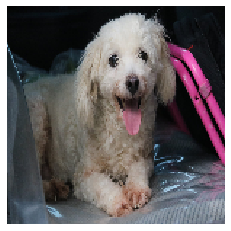

In [51]:
from keras.preprocessing import image

#fn = "dollar_sink.jpg" 
fn = "maam.jpeg"

# predicting images
path='content/' + fn
img=image.load_img(path, target_size=(150, 150))
plt.imshow(img)
plt.axis('off')
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=10)
  
print(classes[0])
  
if classes[0]>0:
    print(fn + " is a dog")
else:
    print(fn + " is a cat")

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler 
from tensorflow.keras.optimizers import Adam

## 4.3 การแต่งเติมช้อมูลภาพ

จากตัวอย่าง 4.2 จะพบว่าโมเดลมีการฟิตเกินเนื่องจากการที่ข้อมูลภาพสำหรับการฝึกมีจำนวนไม่มาก 
การแก้ไขโดยตรงคือเพิ่มจำนวนข้อมูลการฝึก ในกรณีที่ไม่สามารถเพิ่มข้อมูลได้ สามารถใช้วิธีแต่งเติมภาพ 
(image augmentation) โดยหลักการคือใช้กรรมวิธีประมวลผลภาพกับภาพเดิมที่มีอยู่เพื่อให้ได้ข้อมูลฝึกเพิ่มขึ้น 
ตัวอย่างเช่นสมมุติภาพแมวทั้งหมดที่หาได้มีส่วนหูอยู่ในแนวตั้ง ซึ่งอาจเป็นลักษณะเด่นที่โมเดล CNN ใช้ตัดสินใจ 
แต่เมื่อทดสอบโมเดลด้วยภาพแมวที่ไต่ลงจากกิ่งไม้ลาดชัน หรือแมวในท่านอน หูของแมวเอียงทำมุมกับแกนหลักของภาพ ทำให้โมเดลจำแนกผิดพลาด 
ดังนั้นหากหมุนภาพเดิมเพื่อใช้ในกาฝึกอาจช่วยให้การจำแนกภาพแมวทำได้แม่นยำขึ้น การแต่งเติมภาพโดยทั่วไปทำได้
โดยการคัดเลือกเฉพาะบางส่วนของภาพ การพลิกในแนวตั้งและแนวนอน การหมุน การเฉือน การปรับแต่งสี 
หรือการดำเนินการอื่นที่ผู้พัฒนาเห็นว่าเป็นประโยชน์ต่อโจทย์ปัญหา รูปที่ 4.17 
แสดงตัวอย่างการแต่งเติมภาพแมวเพื่อเพิ่มความหลากหลายของข้อมูลฝึก

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1RPQuklHsnF3S-eq6QaB0SjeHPhyHNZ_w" width=550 />
</p>
<div align="center">รูปที่ 4.17 การแต่งเติมภาพโดยการกลับด้าน หมุนและเฉือน </div>

**ตัวอย่าง 4.4** 
 
สมมุติว่าเราต้องการแก้ปัญหาการฟิตเกินในตัวอย่าง 4.2 แต่ไม่สามารถหาภาพเพิ่มเติมสำหรับฝึกได้ จึงต้องการใช้วิธีการแต่งเติมภาพที่มีอยู่  
ซึ่งสามารถใช้คลาส ImageDataGenerator ช่วย ซึ่งมีข้อดีคือไม่จำเป็นต้องเปลืองทรัพยากรสำหรับเก็บข้อมูลภาพที่แต่งเติมแล้ว 
แต่จะโหลดภาพที่มีและจัดการในหน่วยความจำโดยไม่ต้องจัดเก็บ ในตัวอย่างนี้จะทดลองตั้งค่าอาร์กิวเมนต์ดังนี้



In [21]:
train_datagen_a = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

คำอธิบายโดยย่อสำหรับแต่ละอาร์กิวเมนต์ที่ใช้

* rescale : ปรับมาตราส่วนแต่ละพิกเซลจาก 0-255 ให้อยู่ในช่วง 0 - 1
* rotation_range : ค่ามุมในการหมุนภาพแบบสุม ในช่วง 0 - 180 องศา (จากตัวอย่างตั้งค่าเท่ากับ 40 องศา)
* width_shift_range : อัตราส่วนในการเลื่อนภาพแบบสุ่มในแนวนอน (จากตัวอย่างตั้งค่าเท่ากับ 20 เปอร์เซนต์)
* height_shift_range : อัตราส่วนในการเลื่อนภาพแบบสุ่มในแนวตั้ง (จากตัวอย่างตั้งค่าเท่ากับ 20 เปอร์เซนต์)
* shear_range : ย่านที่ตั้งสำหรับการเฉือนแบบสุ่ม (จากตัวอย่างตั้งค่าเท่ากับ 20 เปอร์เซนต์)
* zoom_range : ย่านที่ตั้งสำหรับการขยายแบบสุ่ม (จากตัวอย่างตั้งค่าเท่ากับ 20 เปอร์เซนต์)
* horizontal_flip : กลับภาพซ้ายขวาแบบสุ่มจำนวนครึ่งหนึ่งของภาพทั้งหมด (จากตัวอย่างตั้งค่าจริงเพื่อให้มีการกลับภาพ)
* fill_mode : กำหนดว่าจะตั้งค่าพิกเซลที่อาจขาดหายไปจากการดำเนินการอย่างไร (จากตัวอย่างตั้งให้ใช้ค่าพิกเซลใกล้เคียง)
    
การแต่งเติมภาพจะกระทำกับภาพที่ใช้ฝึกเท่านั้น สำหรับข้อมูลภาพที่ใช้ทดสอบต้องการเพียงปรับมาตราส่วนเท่านั้น

In [22]:
test_datagen_a = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator_a = train_datagen_a.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
validation_generator_a =  test_datagen_a.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


ใช้โมเดลเดิมจากตัวอย่าง 4.2 (กำหนดชื่อใหม่ว่า model_a เพื่อไม่ให้ซ้ำ) ในการฝึกและทดสอบ เพิ่มจำนวนรอบการฝึกเป็น 50 
รอบเพื่อให้เห็นข้อมูลจากการฝึกได้ชัดเจนขึ้น

In [70]:
model_a = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2), 
    Conv2D(64, (3,3), activation='relu'), 
    MaxPooling2D(2,2),
    Flatten(), 
    Dense(512, activation='relu'), 
    Dense(1, activation='sigmoid')  
])
model_a.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])
history_a = model_a.fit(train_generator_a,
                              validation_data=validation_generator_a,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_steps=50,
                              verbose=2)


Epoch 1/50
100/100 - 23s - loss: 0.7985 - accuracy: 0.5320 - val_loss: 0.6901 - val_accuracy: 0.5190
Epoch 2/50
100/100 - 26s - loss: 0.6888 - accuracy: 0.5745 - val_loss: 0.6326 - val_accuracy: 0.6740
Epoch 3/50
100/100 - 23s - loss: 0.6503 - accuracy: 0.6380 - val_loss: 0.6180 - val_accuracy: 0.6280
Epoch 4/50
100/100 - 26s - loss: 0.6432 - accuracy: 0.6455 - val_loss: 0.5939 - val_accuracy: 0.6640
Epoch 5/50
100/100 - 26s - loss: 0.6405 - accuracy: 0.6675 - val_loss: 0.5611 - val_accuracy: 0.7060
Epoch 6/50
100/100 - 24s - loss: 0.6118 - accuracy: 0.6730 - val_loss: 0.5924 - val_accuracy: 0.6640
Epoch 7/50
100/100 - 24s - loss: 0.6054 - accuracy: 0.6885 - val_loss: 0.5650 - val_accuracy: 0.7110
Epoch 8/50
100/100 - 27s - loss: 0.6057 - accuracy: 0.6800 - val_loss: 0.5634 - val_accuracy: 0.7150
Epoch 9/50
100/100 - 28s - loss: 0.5863 - accuracy: 0.6835 - val_loss: 0.5342 - val_accuracy: 0.7310
Epoch 10/50
100/100 - 28s - loss: 0.5760 - accuracy: 0.6995 - val_loss: 0.5267 - val_accura

พล็อตค่าความแม่นยำและค่าสูญเสียในรูปที่ 4.18 เมื่อเปรียบเทียบกับข้อมูลฝึกในตัวอย่าง 4.2 
จะเห็นว่าความแม่นยำจากข้อมูลฝึกและทดสอบมีแนวโน้มไปในทิศทางเดียวกัน 
และไม่มีจุดที่ค่าสูญเสียจากข้อมูลทดสอบเพิ่มขึ้นขณะที่ค่าสูญเสียจากการฝึกลดลง อันเป็นสัญญาณบอกถึงการฟิตเกิน 

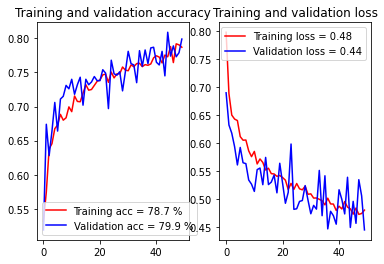

In [71]:
plot_acc_loss(history_a.history)

รูปที่ 4.18 กราฟความแม่นยำและค่าสูญเสียจากข้อมูลฝึกและตรวจสอบ

**ตัวอย่าง 4.5**

พิจารณาปัญหาการจำแนกประเภทที่มีมากกว่าสอง โดยใช้ข้อมูลภาพมือที่แทนวัตถุ 3 ประเภทคือ ก้อนหิน กรรไกร และกระดาษ 
ซึ่งเราคงเคยเล่นในสมัยเด็ก ใช้ข้อมูลภาพที่สร้างโดยคอมพิวเตอร์จาก 
https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset 
ตัวอย่างของภาพแสดงในรูปที่ 4.19 สามารถโหลดข้อมูลจากเว็บเพื่อศึกษาได้โดยให้เครดิตกับเจ้าของข้อมูลคือ
Laurence Moroney


<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1MgZft29dwp0ZZIe6BZIsrt6XC68uHjQQ" width=650 />
</p>
<div align="center">รูปที่ 4.19 ตัวอย่างภาพมือที่แทนก้อนหิน กรรไกร กระดาษ https://laurencemoroney.com/ </div>

วิธีการที่สะดวกคือใช้โปรแกรม wget เพื่อดาวน์โหลดไฟล์เก็บที่ไดเรคทอรี /tmp


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2022-06-08 11:46:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.200.16, 216.58.221.208, 142.250.199.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.200.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   922KB/s    in 3m 39s  

2022-06-08 11:49:47 (895 KB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2022-06-08 11:49:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.199.240, 216.58.221.208, 142.250.199.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.199.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/r

แยกไดเรคทอรีสำหรับภาพฝึกและทดสอบ ภายในไดเรคทอรีย่อยสำหรับภาพฝึก แยกหมวดหมู่สำหรับภาพก้อนหิน กระดาษ กรรไกร

In [5]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [6]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('จำนวนภาพก้อนหินทั้งหมด :', len(os.listdir(rock_dir)))
print('จำนวนภาพกระดาษทั้งหมด :', len(os.listdir(paper_dir)))
print('จำนวนภาพกรรไกรทั้งหมด :', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
#print(rock_files[:10])
paper_files = os.listdir(paper_dir)
#print(paper_files[:10])
scissors_files = os.listdir(scissors_dir)
#print(scissors_files[:10])

จำนวนภาพก้อนหินทั้งหมด : 840
จำนวนภาพกระดาษทั้งหมด : 840
จำนวนภาพกรรไกรทั้งหมด : 840


ประมวลผลภาพอินพุตโดยใช้ ImageDataGenerator เช่นเดียวกับตัวอย่าง 4.4 เพียงแต่เปลี่ยนอาร์กิวเมนต์ class_mode='categorical' 
เนื่องจากคลาสในตัวอย่างนี้ไม่เป็นแบบทวิภาค แต่มีจำนวน 3 คลาส

In [7]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
    batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
    batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


สร้างโมเดล CNN ประกอบด้วยชั้นสังวัตนาการและพูลลิง 4 คู่ และปิดท้ายด้วยชั้นเชื่อมต่อเต็ม 
โดยมีดรอปเอาต์เพื่อลดผลการฟิตเกิน ผู้อ่านสามารถทดลองปรับไฮเปอร์พารามิเตอร์ตามต้องการ 

In [10]:
model_rps = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

In [11]:
model_rps.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

คอมไพล์โดยกำหนดอาร์กิวเมนต์ฟังก์ชันสูญเสียแบบ categorical_crossentropy เลือกตัวหาค่าเหมาะที่สุดตามต้องการ 
หลังจากนั้นทดลองฝึกโมเดล 25 รอบ (อาจใช้เวลานานขึ้นกับสมรรถนะคอมพิวเตอร์ที่ใช้)

In [12]:
model_rps.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [13]:
history_rps = model_rps.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

Epoch 1/25
20/20 [==============================] - 52s 2s/step - loss: 1.3081 - accuracy: 0.3631 - val_loss: 1.1010 - val_accuracy: 0.3333
Epoch 2/25
20/20 [==============================] - 52s 3s/step - loss: 1.0921 - accuracy: 0.3770 - val_loss: 1.0308 - val_accuracy: 0.7285
Epoch 3/25
20/20 [==============================] - 57s 3s/step - loss: 1.0839 - accuracy: 0.4893 - val_loss: 0.8145 - val_accuracy: 0.4435
Epoch 4/25
20/20 [==============================] - 51s 3s/step - loss: 0.9450 - accuracy: 0.5286 - val_loss: 0.8513 - val_accuracy: 0.4919
Epoch 5/25
20/20 [==============================] - 52s 3s/step - loss: 0.8494 - accuracy: 0.5980 - val_loss: 0.3650 - val_accuracy: 0.9892
Epoch 6/25
20/20 [==============================] - 52s 3s/step - loss: 0.7399 - accuracy: 0.6790 - val_loss: 0.2772 - val_accuracy: 0.9785
Epoch 7/25
20/20 [==============================] - 49s 2s/step - loss: 0.5650 - accuracy: 0.7468 - val_loss: 0.2052 - val_accuracy: 0.9731
Epoch 8/25
20/20 [==

หากต้องการบันทึกโมเดลที่ฝึกแล้ว ใช้คำสั่ง

In [16]:
model_rps.save("model_rps.h5")

หรือหากต้องการเก็บข้อมูลจากการฝึกในดิกชันนารี history_rps

In [15]:
import json
with open('history_rps.json', 'w') as file:
    json.dump(history_rps.history, file)

คำสั่งโหลดโมเดลที่บันทึกไว้

In [ ]:
from tensorflow.keras.models import load_model
model_rps_trained = load_model('model_rps.h5')

คำสั่งโหลดข้อมูลการฝึก

In [18]:
with open('history_rps.json') as json_file:
    saved_history_rps = json.load(json_file)

ตรวจสอบข้อมูลจากการฝึกดังในรูปที่ 4.20 จะเห็นว่าโดยรวมแล้วแนวโน้มของความแม่นยำและค่าสูญเสียจากข้อมูลฝึกและตรวจสอบไปในทิศทางเดียวกัน 
เป็นสัญญาณที่ดีว่าการฟิตเกินไม่ใช่ปัญหา


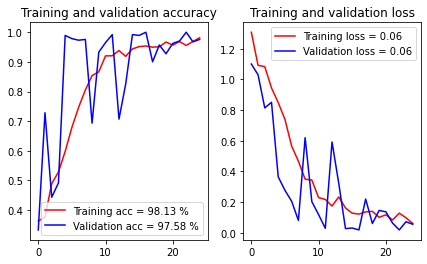

In [24]:
plot_acc_loss(history_rps.history)
#plot_acc_loss(saved_history_rps)

รูปที่ 4.20 ความแม่นยำและค่าสูญเสียจากการฝึกโมเดลในตัวอย่าง 4.5

ผู้อ่านสามารถทดสอบจากภาพมือของตนเอง โดยถ่ายภาพมือที่ทำเป็นรูปอย่างใดอย่างหนึ่งใน 3 ประเภทแล้วใส่ในไดเรคทอรี test 
ในเซลล์ด้านล่างตั้งชื่อตัวแปร fn ให้ตรงกับชื่อไฟล์ และรันโค้ดในเซลล์

paper.jpg
ผลพยากรณ์ --> กรรไกร


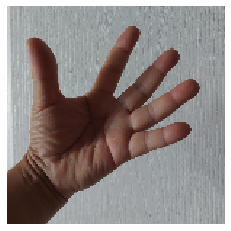

In [72]:
import numpy as np
from keras.preprocessing import image
import keras 

fn = "paper.jpg"
  
# predicting images
path = "test/" + fn
img = tf.keras.utils.load_img(path, target_size=(150, 150))
plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model_rps.predict(images, batch_size=10)
print(fn)
if np.argmax(classes) == 0:
    print("ผลพยากรณ์ --> ก้อนหิน")
elif np.argmax(classes) == 1:
    print("ผลพยากรณ์ --> กระดาษ")
elif np.argmax(classes) == 2:
    print("ผลพยากรณ์ --> กรรไกร")

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>